In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LeakyReLU

import keras_tuner
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, Callback

!pip install shap
import shap
import pickle
import copy

import seaborn as sns; sns.set_theme()
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib as mlp

import lime
import lime.lime_tabular

/tmp/ipykernel_23/3869030795.py:18: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
inp = pd.read_csv("/kaggle/input/a1101-data/A1101.csv", header = 0, low_memory=False, sep=",")
inp.index = range(len(inp))
inp.head()

inp = inp.groupby('sequence', as_index=False).mean()
inp

,sequence,intensity
0,AAAATSAGTR,0.253411
1,AAASSLLYK,0.748583
2,AAATSAGTR,0.231444
3,AAATSAGTRR,0.341356
4,AAAYFVGYLK,1.000000
...,...,...
6278,YYKDDISYF,0.084687
6279,YYLEKANKI,0.084687
6280,YYPEDPVKL,0.084687
6281,YYQLCQHLK,0.469617


In [3]:
#Tạo list các axit amin để encoding
peptides = inp['sequence'].tolist()
peptides.sort()
vocab = set(''.join([str(i) for i in peptides]))
vocab.add('END')
vocab_list = list(vocab)
vocab_list.sort()
#vocab_list

#Thêm END vào các peptides dài 8-9 có độ dài 10 
char_index = dict((vocab_list[i], i) for i in range(len(vocab_list)))
X = []
x_name = [str(i)[0:10] for i in peptides]
for i in x_name:
    tmp = [char_index[j] for j in str(i)]
    for k in range(0,10 - len(str(i))):
        tmp.append(char_index["END"])
    X.append(tmp)
#X

#Tạo list chứa toàn bộ giá trị CCS
Y = []
for index, row in inp.iterrows():
    my_list = [row.intensity]
    Y.append(my_list)
#all_int_list[0]

X = np.asarray(X)
Y = np.asarray(Y)

In [4]:
#Chia thành tập train, test, val
x_train_all, x_test, y_train_all, y_test = train_test_split(X,Y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=42)

In [ ]:
np.savetxt('CCS_x_test.txt', x_test)
np.savetxt('CCS_y_test.txt', y_test)
np.savetxt('CCS_x_train.txt', x_train)
np.savetxt('CCS_y_train.txt', y_train)
np.savetxt('CCS_x_val.txt', x_val)
np.savetxt('CCS_y_val.txt', y_val)

In [5]:
x_train = np.loadtxt('/kaggle/input/a1101-data/A1101_x_train.txt')

x_test = np.loadtxt('/kaggle/input/a1101-data/A1101_x_test.txt')

y_train = np.loadtxt('/kaggle/input/a1101-data/A1101_y_train.txt')

y_test = np.loadtxt('/kaggle/input/a1101-data/A1101_y_test.txt')

x_val = np.loadtxt('/kaggle/input/a1101-data/A1101_x_val.txt')

y_val = np.loadtxt('/kaggle/input/a1101-data/A1101_y_val.txt')

In [6]:
%%time

#Model LSTM 
model = Sequential()
model.add(Embedding(output_dim = 50, input_dim = 21, input_length = 10))

model.add(LSTM(128,return_sequences=True, input_shape=(10,21)))
model.add(Dropout(0.5333324976566283))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5630981705545706))

model.add(Dense(64))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.7995520644054326))

model.add(Dense(1))

optimizermodel = tf.keras.optimizers.Adam(0.001)
optimizermodel.learning_rate.assign(0.01)
model.compile(loss='mse', optimizer = optimizermodel, metrics=['mse'])

hist = model.fit(x_train, y_train,
                batch_size = 5000,
                epochs = 200,
                validation_data = (x_val, y_val))



Epoch 1/200


Argument `input_length` is deprecated. Just remove it.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
Argument `alpha` is deprecated. Use `negative_slope` instead.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.1787 - mse: 0.1787 - val_loss: 0.1930 - val_mse: 0.1930
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2932 - mse: 0.2932 - val_loss: 0.2304 - val_mse: 0.2304
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3679 - mse: 0.3679 - val_loss: 0.9402 - val_mse: 0.9402
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.5286 - mse: 1.5286 - val_loss: 1.1453 - val_mse: 1.1453
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 1.4096 - mse: 1.4096 - val_loss: 0.0905 - val_mse: 0.0905
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.1990 - mse: 0.1990 - val_loss: 0.0893 - val_mse: 0.0893
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.1658 - mse: 0.1658 - val_loss: 0.1155 - val_mse: 0.1155
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1430 - mse: 0.1430 - val_loss: 0.1195 - val_mse: 0.1195
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.1515 - mse: 0.1515 - val_l

In [7]:
y_pred = model.predict(x_test)
model_r2 = r2_score(y_test, y_pred)
model_mae = mean_absolute_error(y_test, y_pred)
model_mse = mean_squared_error(y_test, y_pred)
print(model_r2, model_mae, model_mse)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
0.6679456671702111 0.1324183601247707 0.03006325059380596


In [8]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(output_dim=50, input_dim=21, input_length=10))

    model.add(GRU(hp.Int('units_1', min_value=32, max_value=128, step=32),
                  return_sequences=True, input_shape=(10, 21)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.8)))

    model.add(GRU(hp.Int('units_2', min_value=32, max_value=128, step=32)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.8)))

    model.add(Dense(1))

    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01, 0.05])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

    return model

tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=30,  
    executions_per_trial=1,  
    directory='tuner_results',
    project_name='gru_model_tuning_9'
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(x_train, y_train,
             epochs=200,
             batch_size=tuner.oracle.hyperparameters.Choice('batch_size', values=[64, 128, 256, 512]),
             validation_data=(x_val, y_val),
             callbacks=[early_stopping],
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_run = tuner.oracle.get_best_trials(num_trials=1)[0]

best_model.summary()
print(best_run.hyperparameters.values)


Argument `input_length` is deprecated. Just remove it.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |units_1
0.05507           |0.05507           |dropout_1
96                |96                |units_2
0.75047           |0.75047           |dropout_2
0.001             |0.001             |learning_rate
64                |64                |batch_size

Epoch 1/200


Argument `input_length` is deprecated. Just remove it.
Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0957 - mse: 0.0957 - val_loss: 0.0487 - val_mse: 0.0487
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0582 - mse: 0.0582 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0514 - mse: 0.0514 - val_loss: 0.0415 - val_mse: 0.0415
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0483 - mse: 0.0483 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0456 - mse: 0.0456 - val_loss: 0.0381 - val_mse: 0.0381
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0453 - mse: 0.0453 - val_loss: 0.0365 - val_mse: 0.0365
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0431 - mse: 0.0431 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 8/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 9/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0400 - mse: 0.

KeyboardInterrupt: 

In [9]:
%%time

#model GRU
model1 = Sequential()
model1.add(Embedding(output_dim = 50, input_dim = 21, input_length = 10))

model1.add(GRU(32, return_sequences=True))
model1.add(Dropout(0.2810055403004359))

model1.add(GRU(32))
model1.add(Dropout(0.18264347914316714))

model1.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(0.001)

model1.compile(loss='mse', optimizer=optimizer)
model1.fit(x_train, y_train, 
           epochs = 100, 
           batch_size = 512, 
           validation_data = (x_val, y_val))

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1316 - val_loss: 0.0862
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0817 - val_loss: 0.0702
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0710 - val_loss: 0.0602
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0642 - val_loss: 0.0546
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0593 - val_loss: 0.0514
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0565 - val_loss: 0.0492
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0538 - val_loss: 0.0470
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0520 - val_loss: 0.0453
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0517 - val_loss: 0.0445
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0497 - val_loss: 0.0441
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0497 - val_loss: 0.0437
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0492 - val_loss: 0.0432


In [10]:
y_pred1 = model1.predict(x_test)
model1_r2 = r2_score(y_test, y_pred1)
model1_mae = mean_absolute_error(y_test, y_pred1)
model1_mse = mean_squared_error(y_test, y_pred1)
print(model1_r2, model1_mae, model1_mse)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
0.6701709374545141 0.12711305680211765 0.029861780980005605


In [11]:
#Chọn model
model = model1

**SHAP**

In [ ]:
%%time

#Tạo 100 cụm dữ liệu để tính toán SHAP
x_trainmeans = shap.kmeans(np.asarray(x_train), 100)
explainer = shap.KernelExplainer(model.predict, x_trainmeans)
shap_values = explainer.shap_values(np.asarray(x_test))

#lưu giá trị SHAP
with open("A1101_shapvalues_GRU.pkl","wb") as f:
    pickle.dump(shap_values, f)

In [21]:
with open("/kaggle/input/a1101-data/shapvaluesA1101.pkl","rb") as f:
    shap_values = pickle.load(f)

print(shap_values[0][0][0])

0.03799275171633592


**LIME**

In [ ]:
%%time

#Định nghĩa hàm giải thích LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = x_train,
    mode = 'regression',
    feature_names = [f'Pos{i+1}' for i in range(10)],
)
positions = [f'Pos{i+1}' for i in range(10)]

lime_values = []
for i in range(len(x_test)):
    x_instance = x_test[i]
    ordered_contributions = {pos: 0.0 for pos in positions}

    #Tính LIME cho từng instance
    exp = explainer.explain_instance(
        data_row = x_instance,
        predict_fn = model.predict
    )

    for feature_value, contribution in exp.as_list():
        pos = next((word for word in feature_value.split() if word.startswith('Pos')), None)
        if pos in ordered_contributions:
            ordered_contributions[pos] += contribution

    contributions_sorted = [ordered_contributions[pos] for pos in positions]
    lime_values.append(contributions_sorted)

with open('A1101_lime_values_LSTM.pkl', 'wb') as f:
    pickle.dump(lime_values, f)

In [14]:
with open('/kaggle/input/a1101-data/A1101_lime_values_LSTM.pkl', 'rb') as f:
    lime_values = pickle.load(f)

**OSA**

In [15]:
%%time

#Tính OSA
baseline = 0
original_output = model.predict(x_test).flatten()
osa_values = np.zeros_like(x_test, dtype=np.float32)

for i in range(10):
    osa_inputs = x_test.copy()
    osa_inputs[:,i] = baseline
    osa_output = model.predict(osa_inputs).flatten()

    osa_values[:,i] = np.abs(original_output - osa_output)



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CPU times: user 1.14 s, sys: 80.1 ms, total: 1.22 s
Wall time: 997 ms


**HEATMAP**

In [23]:
#Tạo mảng lưu các giá trị SHAP/LIME/OSA của 1 axit amin ở cùng 1 vị trí (pos=[1,10])

#Chọn giá trị
explain_values = shap_values

aa = []
i = 0
while i < 10:
    aa.append([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0]])
    i+=1

i=0
while i < len(x_test):
    j = 0
    while j < len(x_test[i]):
        aa[j][int(x_test[i][j])].append(explain_values[0][i][j])
        j+=1
    i+=1

heatmap = []

i = 0
while i < len(aa):
    j = 0
    heatmap.append([])
    while j < len(aa[i]):
        if len(aa[i][j]) > 1:
            aa[i][j] = aa[i][j][1:]
            heatmap[i].append(sum(aa[i][j])/float(len(aa[i][j])))
        else:
            heatmap[i].append(0)
        j+=1
    i+=1
heatmap = np.array(heatmap)

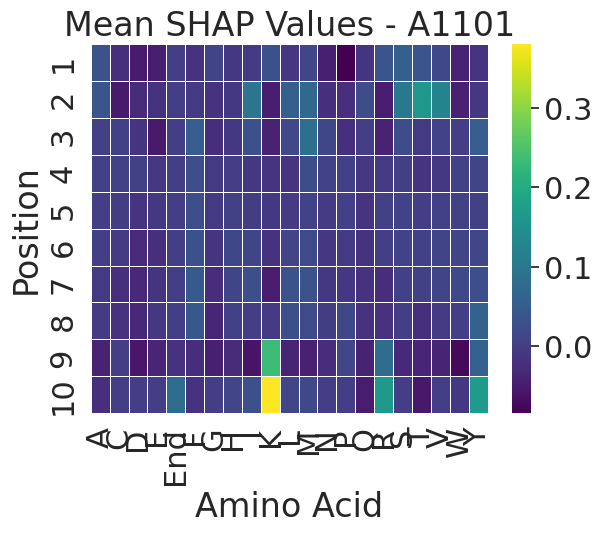

In [24]:
plt.figure()
x_axis_labels = ['A','C','D','E','End','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y'] # labels for x-axis
y_axis_labels = ['1','2','3','4','5','6','7','8','9','10']
sns.set(font_scale = 2)

rcParams['figure.figsize'] = 20,16
ax = sns.heatmap(heatmap,xticklabels=x_axis_labels, yticklabels=y_axis_labels,linewidths=.5,  cmap="viridis")

ax.set(xlabel='Amino Acid', ylabel='Position', title='Mean SHAP Values - A1101')
ax.figure.savefig('A1101.png')
plt.show()